# Lendify Data Engineer Test


In [66]:
# P1. Do some exploratory analysis and provide your most (i.e. 2 - 3) interesting findings.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import Database_functions

# Cancels chained assignments warnings
pd.options.mode.chained_assignment = None 

# Read csv file
df = pd.read_csv(r"Bundesliga_Results.csv")

# The csv file has the structure Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season

# 1. Checking that all of the teams that played home also played Away. Only got one nan value not matching.
Teams = df.AwayTeam.unique()[[a in df.HomeTeam.unique() for a in df.AwayTeam.unique()]]

# 2. Some faulty data. Doesn't matter too much. Matters most to calculate season ends index. 2017/18 instead of 2017-18
# Correct 2017/18 to 2017-18
df.Season = df.Season.str.replace('/','-')

# Calculate the start and end indices of the seasons
Season_period = {}
for ind, season_1 in enumerate(df.Season.unique()):
    
    if season_1 == '1993-94':
        Season_period[df.Season.unique()[ind]] = [0]
        pass
    else:
        Season_period[df.Season.unique()[ind-1]].append(df.index[(df.Season==season_1)][0])
        Season_period[df.Season.unique()[ind]] = [df.index[(df.Season==season_1)][0]]
        
        if ind == len(df.Season.unique())-1:
            Season_period[df.Season.unique()[ind]].append(df.index[(df.Season==season_1)][-1])
           
        
# 3. The Missing values for HTHG, HTAG, and HTR values for the 1993/1994 and 1994/1995 seasons.
# Will handle this by filling in the mean values of these values for the team in question.
Missing_stat_int = ['HTHG', 'HTAG']

for team in Teams:
    ind_1, ind_2 = Season_period['1993-94']
    ind_3, ind_4 = Season_period['1994-95']
    ind_5, ind_6 = Season_period['2017-18']
    
    # Fill HTHG and HTAG with the means of these of those teams
    for stat in Missing_stat_int:
        if df[stat][ind_4:ind_6][df.AwayTeam[ind_4:ind_6] == team].to_list() and df[stat][ind_4:ind_6][df.HomeTeam[ind_4:ind_6] == team].to_list():
            df[stat][ind_1:ind_4][df.AwayTeam[ind_1:ind_4] == team] = round(df[stat][ind_4:ind_6][df.AwayTeam[ind_4:ind_6] == team].mean())
            df[stat][ind_1:ind_4][df.HomeTeam[ind_1:ind_4] == team] = round(df[stat][ind_4:ind_6][df.HomeTeam[ind_4:ind_6] == team].mean())

    
    # Two options for HTR. Either check the mean goals we just inserted or use the final result.
    # Since we are filling in data we should use our approximated goals to determine who is in the lead.
    # Problem is that if we use the mean we get a float. We typecast to int by round since this takes into consideration
    # the float part of the median.
    
    ind_index = ind_1
    for goals_1 in df['HTHG'][ind_1:ind_4][df.HomeTeam[ind_1:ind_4] == team]:
        
        real_index = df.index[ind_1:ind_4][df.HomeTeam[ind_1:ind_4] == team][ind_index]
        
        for goals_2 in df['HTAG'][ind_1:ind_4][df.HomeTeam[ind_1:ind_4] == team]:
            
            if goals_1 > goals_2:
                df.HTR[real_index] = 'H'
            elif goals_1 < goals_2:
                df.HTR[real_index] = 'A'
            else:
                df.HTR[real_index] = 'D'
                
        ind_index += 1
          
    ind_index = ind_1
    for goals_1 in df['HTAG'][ind_1:ind_4][df.AwayTeam[ind_1:ind_4] == team]:
        
        real_index = df.index[ind_1:ind_4][df.AwayTeam[ind_1:ind_4] == team][ind_index]
        
        for goals_2 in df['HTHG'][ind_1:ind_4][df.AwayTeam[ind_1:ind_4] == team]:
            if goals_1 > goals_2:
                df.HTR[real_index] = 'A'
            elif goals_1 < goals_2:
                df.HTR[real_index] = 'H'
            else:
                df.HTR[real_index] = 'D'
        ind_index += 1
    

## P2:

- We wish to know which are the best Bundesliga teams over the entire period. 
- Define a metric, that you think is fair, to rank the teams over time. 
- Compute the top 10 teams over the entire period.


So since I do not know anything about football I first had to find out how the ranking and the seasons work.
This lead me to the scoring system with 3 points for each win and 1 point for each draw.
 
I further realised since the goal is to get the best teams over the entire period, that I can think of the entire period as one big season and compute the score over that season instead.

To ensure that this would get the best team I also included data such as `Home_wins`, `Total_goals`, `Away_wins`, `Scored_on` and `Titles` to get the truly best overall team. `Home_wins` gets the best home team, `Away_wins` gets the best away team and `Scored_on` is the average goals the opposing team has scored on the team over the entire period. This will be the measure of the most defensive team. `Titles` is the amount of times the team has won a season. 












               Home_wins  Home_goals  Away_wins  Away_goals  Score  \
Bayern Munich        320        1090        229         751   1820   
Dortmund             258         854        157         651   1472   
Leverkusen           235         857        165         660   1418   
Schalke 04           226         720        142         514   1333   
Werder Bremen        219         795        136         623   1270   
Stuttgart            202         689        120         545   1176   
Hamburg              195         646        111         497   1148   
Wolfsburg            175         634         93         435    988   
M'gladbach           167         589         78         389    920   
Hertha               157         509         88         367    895   

               Total_goals  Goals_scored_on  Titles  
Bayern Munich         1841         0.898824      15  
Dortmund              1505         1.169412       5  
Leverkusen            1517         1.253985       1  
Schalke 04   

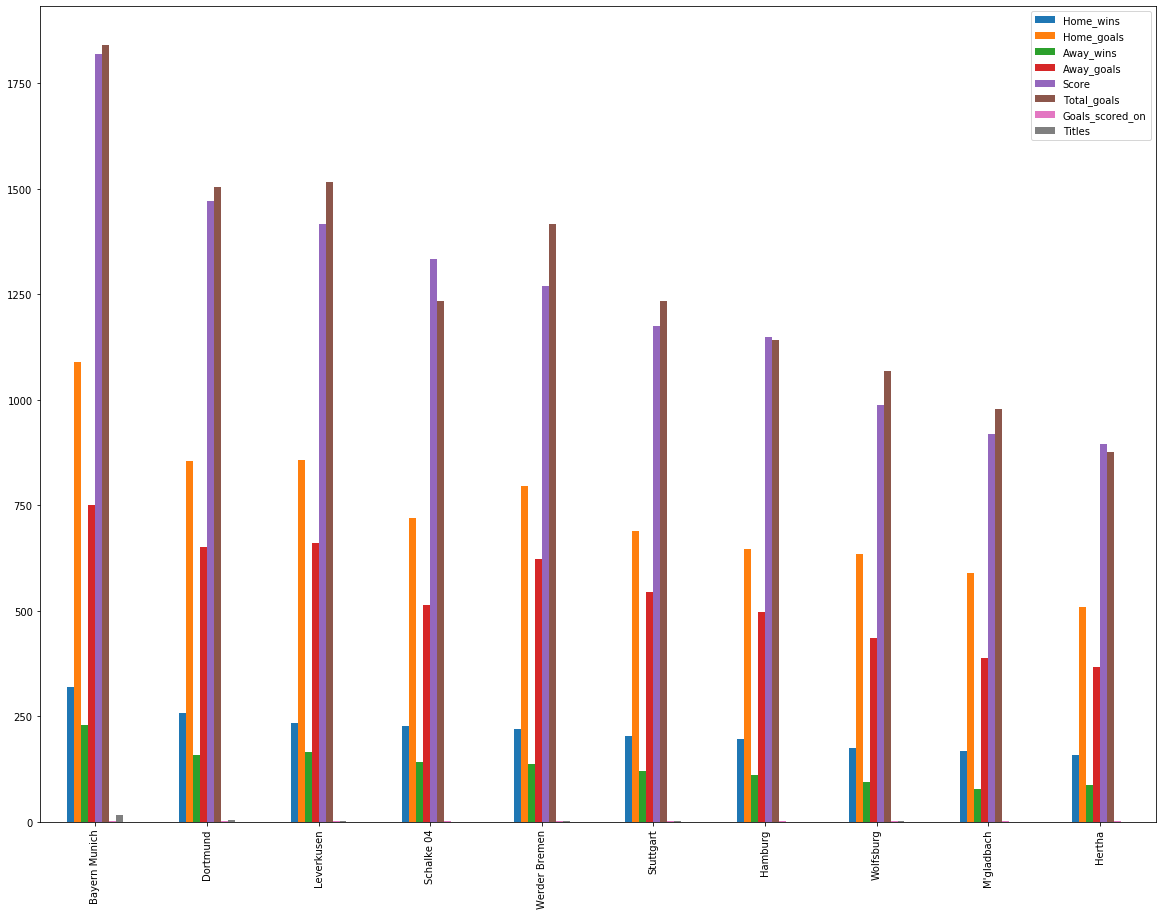

In [67]:
Team_stats = {}
Team_stats['Home_wins'] = {}
Team_stats['Home_draw'] = {}
Team_stats['Home_goals'] = {}
Team_stats['Away_wins'] = {}
Team_stats['Away_draw'] = {}
Team_stats['Away_goals'] = {}
Team_stats['Score'] = {}
Team_stats['Total_goals'] = {}
Team_stats['Goals_scored_on'] = {}
Team_stats['Titles'] = {}

Team_stats['Half_time_home_goals'] = {}
Team_stats['Half_time_home_wins'] = {}
Team_stats['Half_time_home_draws'] = {}
Team_stats['Half_time_away_goals'] = {}
Team_stats['Half_time_away_wins'] = {}
Team_stats['Half_time_away_draws'] = {}

Season_stats = {}
Season_stats['Total_goals'] = {}
Season_stats['Season_score'] = {}

# Calculates the seasonal stats to get the season title winner
for season in Season_period:
    ind_1, ind_2 = Season_period[season]
    
    for team in Teams:
        
        if team not in Team_stats['Titles']:
            Team_stats['Titles'][team] = 0
            
        Season_home_wins = sum(df.HomeTeam[ind_1:ind_2][df.FTR[ind_1:ind_2]=='H'] == team)
        Season_home_draws = sum(df.HomeTeam[ind_1:ind_2][df.FTR[ind_1:ind_2]=='D'] == team)
        Season_home_goals = sum(df.FTHG[ind_1:ind_2][df.HomeTeam[ind_1:ind_2] == team].dropna())

        Season_away_wins = sum(df.AwayTeam[ind_1:ind_2][df.FTR[ind_1:ind_2]=='A'] == team)
        Season_away_draws = sum(df.AwayTeam[ind_1:ind_2][df.FTR[ind_1:ind_2]=='D'] == team)
        Season_away_goals = sum(df.FTAG[ind_1:ind_2][df.AwayTeam[ind_1:ind_2] == team].dropna())
        
        Season_stats['Season_score'][team] = (Season_home_wins+Season_away_wins)*3+(Season_home_draws+Season_away_draws)
        Season_stats['Total_goals'][team] = Season_home_goals + Season_away_goals
        
    best_team = 'One Team'
    best_score = 0
    goals_best_team = 0
    
    for team in Season_stats['Season_score']:
        if Season_stats['Season_score'][team] > best_score:
            best_score = Season_stats['Season_score'][team]
            best_team = team
            goals_best_team = Season_stats['Total_goals'][team]
        
        # If they have equal score, compare the goals.
        elif Season_stats['Season_score'][team] == best_score and Season_stats['Total_goals'][team] > goals_best_team:
            best_score = Season_stats['Season_score'][team]
            best_team = team
            goals_best_team = Season_stats['Total_goals'][team]
            
    Team_stats['Titles'][best_team] += 1
    
# To calculate the best team over the entire period I consider the whole period as one season
for team in Teams:
    
    Home_wins = sum(df.HomeTeam[df.FTR=='H'] == team)
    Home_draws = sum(df.HomeTeam[df.FTR=='D'] == team)
    Home_goals = sum(df.FTHG[df.HomeTeam == team].dropna())
    
    Away_wins = sum(df.AwayTeam[df.FTR=='A'] == team)
    Away_draws = sum(df.AwayTeam[df.FTR=='D'] == team)
    Away_goals = sum(df.FTAG[df.AwayTeam == team].dropna())
    
    Goals_scored_on = ((df.FTAG[df.HomeTeam == team].dropna()).mean() + (df.FTHG[df.AwayTeam == team].dropna()).mean())/2
    
    
    Half_time_home_goals = sum(df.HTHG[df.HomeTeam == team].dropna())
    Half_time_home_wins = sum((df.HTR[df.HomeTeam == team].dropna()) =='H')
    Half_time_home_draws = sum((df.HTR[df.HomeTeam == team].dropna()) =='D')
    
    Half_time_away_goals = sum(df.HTAG[df.AwayTeam == team].dropna())
    Half_time_away_wins = sum((df.HTR[df.AwayTeam == team].dropna()) =='A')
    Half_time_away_draws = sum((df.HTR[df.AwayTeam == team].dropna()) =='D')
    
    Team_stats['Half_time_home_goals'][team] = Half_time_home_goals
    Team_stats['Half_time_home_wins'][team] = Half_time_home_wins
    Team_stats['Half_time_home_draws'][team] = Half_time_home_draws
    Team_stats['Half_time_away_goals'][team] = Half_time_away_goals
    Team_stats['Half_time_away_wins'][team] = Half_time_away_wins
    Team_stats['Half_time_away_draws'][team] = Half_time_away_draws
    
    Team_stats['Goals_scored_on'][team] = Goals_scored_on
    Team_stats['Home_wins'][team] = Home_wins
    Team_stats['Home_draw'][team] = Home_draws
    Team_stats['Home_goals'][team] = Home_goals
    
    Team_stats['Away_wins'][team] = Away_wins
    Team_stats['Away_draw'][team] = Away_draws
    Team_stats['Away_goals'][team] = Away_goals
    
    Team_stats['Score'][team] = (Home_wins + Away_wins)*3 + (Home_draws + Away_draws)
    Team_stats['Total_goals'][team] = Home_goals + Away_goals


# Save to store for later usage
Team_df = pd.DataFrame(Team_stats)

# Dropping some data since the plots and data is harder to read.
Top_df_dropped = Team_df.drop(['Half_time_home_goals', 'Half_time_home_wins', 'Half_time_home_draws', 'Half_time_away_goals', 'Half_time_away_wins', 'Half_time_away_draws', 'Home_draw', 'Away_draw'], 1)

# Top k teams parameter
k = 10

# Sort on Score, Titles, Total_goals, Goals_scored_on, Home_wins, Away_wins in descending order of importance.
Top_k_teams = Top_df_dropped.sort_values(['Score', 'Titles', 'Total_goals', 'Goals_scored_on', 'Home_wins', 'Away_wins'], axis = 0, ascending = [False, False, False, True, False, False])[0:k]
print(Top_k_teams)
Top_k_teams.plot(kind='bar', figsize = (20,15))


## P3: 
- Assuming that you are going build a warehouse come up with ideas what are the dimensions, facts you will build, what could be the structure of those and some challenges or questions you may have in order to build scalable DW


Dimensions could be the Teams in question with `Team_name` and `Team_Id`
One fact table could be the matches that the teams have played with `Match_ID`, `Division`, `Date_Played`, `Home_Team`, `Away_Team`, `FTHG`, `FTAG`, `FTR`, `HTHG`, `HTAG`, `HTR`, `Season`.

Another fact table could be the `Team_df` dataframe we created above. This fact table would hold all the team related stats like `Home_wins`, `Home_draw`, `Home_goals`, `Away_wins`, `Away_draw`, `Away_goals`, `Score`, `Total_goals`, `Goals_scored_on`, `Titles`, `Half_time_home_goals`, `Half_time_home_wins`, `Half_time_home_draws`, `Half_time_away_goals`, `Half_time_away_wins`, `Half_time_away_draws` and `Team_Id` to link it to the dimension table.

The seasonal stats was mainly used to calculate the teams with most `Titles` but we could also save this data in a fact table with all of the same values as `Team_df` but with the seasonal data instead. Also linked to the team with `Team_Id`.



## P4: 
- Come up with the ideas how do you take this further (you might have to handle granular data, various formats of data, real time processing etc) to make it more robust and serving all the needs that arise over time for data consumers, Eg. Performance, building real time data pipelines, Handling CI/CD , tools etc

Implement more checks on the input data since this was built around some parts of missing data. If there was data in wrong formats it would not ensure stability.

To take this further I see that it would be good to get the data after each match has finished to get data more frequently and build it with this in mind with the Data Warehouse. Might even get the data as the match is ongoing for outcome predictions. Would have to put design measures in place to ensure this. Like using something like Kafka to ensure when we have maybe multiple data sources streaming that we don't lose it.

More granular data as say data after each match would not be such a problem since it could be treated as an entry in the `Matches` table.
Incase we have streaming data we would need to have separate `Matches_streamed` table for different kinds of data we may get. This may vary from the amount of free kicks the other team gets, number of shots on the goal, positions of the players during the game, where the ball is currently, positions of the referees, this data may be from every second or milliseconds to allow playbacks of the games to analyse how the players played. 

This would also allow to derive lots of different statistics just from the positions of the players and the ball. 
To do this I imagine getting raw video streams directly into `Spark` to run the analysis like `object detection` for players, referees, the field, goals, referees etc. Then we could do some feature extraction like getting the position from these objects and then sending it to `Kafka` and then to our data warehouse from `Kafka`.
Might also want to run some predictive analysis of the game based on this data directly in `Spark`.

Then again sometimes we may not have access to that data source and must have to resort to the after match statistics, having several data sources ensures stability.




# XML Parsing part

In [62]:
import xml.etree.ElementTree as ET

tree = ET.parse('xmldoc2parse.xml')
root = tree.getroot()

# Build up dictionary to hold the data
Data_dict = {}
Data_dict[root.attrib['UserId']] = {}
Data_dict[root.attrib['UserId']][root.attrib['LoanId']] = {}

for child in root:
    Data_dict[root.attrib['UserId']][root.attrib['LoanId']][child.tag] = {}
    
    for key_1 in child.attrib:
        Data_dict[root.attrib['UserId']][root.attrib['LoanId']][child.tag][key_1] = child.attrib[key_1]
    
    Data_dict[root.attrib['UserId']][root.attrib['LoanId']][child.tag]['Results'] = {}
        
    for Result in root.iter('Result'):
        for key_2 in Result.attrib:
            if key_2 == 'Id':
                if key_2 not in Data_dict[root.attrib['UserId']][root.attrib['LoanId']][child.tag]['Results']:
                    Data_dict[root.attrib['UserId']][root.attrib['LoanId']][child.tag]['Results'][Result.attrib['Id']] = {}
                else:
                    pass
            else:
                Data_dict[root.attrib['UserId']][root.attrib['LoanId']][child.tag]['Results'][Result.attrib['Id']][key_2] = Result.attrib[key_2]

# As we now can see the data is now structured in the dict and ready for processing or storage.
# Hierarchy: {UserId: {LoanId: {Rating: {Results: Result_1: {}, Result_2: {} ... Result_N: {} } } } } 
# The Hierarchy of UserId and LoanId is to allow a user to have several LoanIds.
print(Data_dict)
        

{'8f72e5eb-c633-4ec1-a213-e80c966fc89e': {'789879': {'Rating': {'Guid': '07f835c6-e786-43a8-986b-84a9009870d0', 'Name': 'CreditCheck Definition', 'Id': '1', 'DataId': '21', 'Version': '0.1.90', 'EditedDate': '2015-10-16 13:12:18', 'CheckedDate': '2015-11-09 10:25:40', 'Results': {'1': {'Name': 'LoanAmountRangeFlags', 'AdminName': 'Lånebelopp inom ramarna', 'DataType': 'FlagType', 'DataCalc': '(50000) = ', 'CalcDescription': '', 'Data': '50000', 'Result': '0', 'Flag': 'GreenFlag', 'Text': ''}, '2': {'Name': 'LoanTimeRangeFlags', 'AdminName': 'Löptid inom ramarna', 'DataType': 'FlagType', 'DataCalc': '(144) = ', 'CalcDescription': '', 'Data': '144', 'Result': '0', 'Flag': 'GreenFlag', 'Text': ''}, '3': {'Name': 'LoanCountMaxFlags', 'AdminName': 'Max 1 lån', 'DataType': 'FlagType', 'DataCalc': '(2) = ', 'CalcDescription': '', 'Data': '2', 'Result': '0', 'Flag': 'YellowFlag', 'Text': ''}, '4': {'Name': 'CheckUserIsOfProperAge', 'AdminName': 'Minimiålder', 'DataType': 'FlagType', 'DataCalc'